In [1]:
from utils.data_loader import *
from utils.null_handler import *
from utils.model_tuning_utils import *
from utils.analysis_helper import *
from utils.stability_analysis import *
from sys import getsizeof
from sklearn.preprocessing import StandardScaler
from pprint import pprint
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
import numpy as np
import scipy as sp

SEED=10

In [2]:
try:
    from folktables import ACSDataSource, ACSEmployment
except:
    !pip install folktables
    from folktables import ACSDataSource, ACSEmployment
    clear_output()

### Loading ACSEmployment data

In [3]:
config = {
    'state': ["TX"],
    'year': '2016',
    'task': ACSEmployment
}

In [4]:
X_data_load, y_data = ACSDataLoader(task=config['task'], state=config['state'], year=config['year'])

In [5]:
# If the task is ACSEmployment, we can optimize the file size
print(f'Original: {int(getsizeof(X_data_load) / 1024**2)} mb')
print(f'Optimized: {int(getsizeof(optimize_ACSEmployment(X_data_load)) / 1024**2)} mb')

X_data = optimize_ACSEmployment(X_data_load)

Original: 31 mb
Optimized: 16 mb


In [6]:
y_data

array([0, 1, 0, ..., 0, 0, 1])

#### Checking if there are nulls in the dataset

In [7]:
X_data.isnull().sum()

AGEP             0
SCHL          9028
MAR              0
RELP             0
DIS              0
ESP         203843
CIT              0
MIG           2932
MIL          57794
ANC              0
NATIVITY         0
DEAR             0
DEYE             0
DREM         15202
SEX              0
RAC1P            0
dtype: int64

### Preprocessing: Handling nulls

In [8]:
missing = ['SCHL', 'ESP', 'MIG', 'MIL', 'DREM']

In [9]:
handle_nulls = {
'special': ['SCHL','MIG', 'MIL', 'DREM', 'ESP'],
   # 'drop-rows': ['ESP'],
   # 'drop-column': ['ESP']
}

In [10]:
#Checking dataset shape before handling nulls
X_data.shape, X_data.columns

((261896, 16),
 Index(['AGEP', 'SCHL', 'MAR', 'RELP', 'DIS', 'ESP', 'CIT', 'MIG', 'MIL', 'ANC',
        'NATIVITY', 'DEAR', 'DEYE', 'DREM', 'SEX', 'RAC1P'],
       dtype='object'))

In [11]:
for how_to in handle_nulls.keys():
    X_data = handle_df_nulls(X_data, how_to, handle_nulls[how_to])

Impute values:  {'SCHL': 0, 'MIG': 0, 'MIL': 0, 'DREM': 0, 'ESP': 0}


In [12]:
#Checking dataset shape after handling nulls
X_data.shape, X_data.columns

((261896, 16),
 Index(['AGEP', 'SCHL', 'MAR', 'RELP', 'DIS', 'ESP', 'CIT', 'MIG', 'MIL', 'ANC',
        'NATIVITY', 'DEAR', 'DEYE', 'DREM', 'SEX', 'RAC1P'],
       dtype='object'))

#### Rechecking if there are nulls -- if the null_handler has run correctly, there should not be

In [13]:
X_data.isnull().sum()

AGEP        0
SCHL        0
MAR         0
RELP        0
DIS         0
ESP         0
CIT         0
MIG         0
MIL         0
ANC         0
NATIVITY    0
DEAR        0
DEYE        0
DREM        0
SEX         0
RAC1P       0
dtype: int64

### Creating train-test-validation split

In [14]:
X_train_, X_test, y_train_, y_test = train_test_split(X_data, y_data, test_size=0.2, random_state=SEED)
X_train_.shape, X_test.shape

((209516, 16), (52380, 16))

In [15]:
X_train, X_val, y_train, y_val = train_test_split(X_train_, y_train_, test_size=0.25, random_state=SEED)
X_train.shape, X_val.shape

((157137, 16), (52379, 16))

In [16]:
# For computing fairness-related metrics
val_groups = load_groups_of_interest('groups.json', X_val)
test_groups = load_groups_of_interest('groups.json', X_test)

val_groups

{'Race': {'values': array([1, 1, 1, ..., 2, 1, 1]),
  'advantaged': 1,
  'disadvantaged': 2},
 'Sex': {'values': array([2, 1, 1, ..., 1, 2, 1], dtype=int8),
  'advantaged': 1,
  'disadvantaged': 2},
 'Race_Sex': {'values': array(['1_2', '1_1', '1_1', ..., '2_1', '1_2', '1_1'], dtype='<U3'),
  'advantaged': '1_1',
  'disadvantaged': '2_2'}}

### Other data pre-processing (making dummies, scaling etc)

In [17]:
X_data.columns

Index(['AGEP', 'SCHL', 'MAR', 'RELP', 'DIS', 'ESP', 'CIT', 'MIG', 'MIL', 'ANC',
       'NATIVITY', 'DEAR', 'DEYE', 'DREM', 'SEX', 'RAC1P'],
      dtype='object')

In [18]:
def make_feature_df(data, categorical_columns, numerical_columns):
    feature_df = pd.get_dummies(data[categorical_columns], columns=categorical_columns)
    for col in numerical_columns:
        feature_df[col] = data[col]
    return feature_df

In [19]:
categorical_col = ['MAR', 'RELP', 'DIS', 'ESP', 'CIT', 'MIG', 'MIL', 'ANC',
       'NATIVITY', 'DEAR', 'DEYE', 'DREM', 'SEX', 'RAC1P']
numerical_col = ['AGEP', 'SCHL']

In [20]:
X_train_features = make_feature_df(X_train, categorical_col, numerical_col)
X_val_features = make_feature_df(X_val, categorical_col, numerical_col)
X_test_features = make_feature_df(X_test, categorical_col, numerical_col)

In [21]:
X_train_features.shape, X_train.shape

((157137, 74), (157137, 16))

In [22]:
X_train_features

,MAR_1,MAR_2,MAR_3,MAR_4,MAR_5,RELP_0,RELP_1,RELP_2,RELP_3,RELP_4,...,RAC1P_2,RAC1P_3,RAC1P_4,RAC1P_5,RAC1P_6,RAC1P_7,RAC1P_8,RAC1P_9,AGEP,SCHL
183010,0,0,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,7,5.0
146391,0,0,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,16,13.0
102215,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,38,21.0
64752,0,0,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,1,0,10,8.0
213404,0,0,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,16,12.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
178039,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,32,19.0
191169,0,0,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,56,16.0
96680,1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,39,16.0
252801,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,56,22.0


In [23]:
scaler = StandardScaler()
X_train_features = scaler.fit_transform(X_train_features)
X_val_features = scaler.transform(X_val_features)
X_test_features = scaler.transform(X_test_features)

In [24]:
X_train_features

array([[-8.59791602e-01, -2.26808946e-01, -3.06050867e-01, ...,
        -1.63515241e-01, -1.37126353e+00, -1.52890224e+00],
       [-8.59791602e-01, -2.26808946e-01, -3.06050867e-01, ...,
        -1.63515241e-01, -9.86012603e-01, -2.93950178e-01],
       [-8.59791602e-01, -2.26808946e-01,  3.26743071e+00, ...,
        -1.63515241e-01, -4.42881128e-02,  9.41001889e-01],
       ...,
       [ 1.16307254e+00, -2.26808946e-01, -3.06050867e-01, ...,
        -1.63515241e-01, -1.48245413e-03,  1.69156848e-01],
       [ 1.16307254e+00, -2.26808946e-01, -3.06050867e-01, ...,
        -1.63515241e-01,  7.26213743e-01,  1.09537090e+00],
       [-8.59791602e-01, -2.26808946e-01, -3.06050867e-01, ...,
        -1.63515241e-01, -9.43206944e-01, -6.02688194e-01]])

### Quantifying uncertainty using posterior predictive distribution

In [25]:
base_model = DecisionTreeClassifier(criterion='gini', max_depth=10, max_features=0.6)
n_estimators = 50
boostrap_size = int(0.5*X_train_features.shape[0])

___, uq_results = UQ_by_boostrap(X_train_features, y_train, X_val_features, y_val, base_model, n_estimators,
               boostrap_size, with_replacement=True, verbose=False)

In [26]:
def plot_generic(x, y, xlabel, ylabel, plot_title):
    plt.figure(figsize=(20,10))
    plt.scatter(x, y)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(plot_title)
    plt.show()

In [27]:
results = pd.DataFrame(uq_results).transpose()
means = results.mean().values
stds = results.std().values
iqr = sp.stats.iqr(results,axis=0)

y_preds = np.array([int(x<0.5) for x in results.mean().values])
acc = [y_preds[i] == y_val[i] for i in range(len(y_val))]
np.mean(np.array(acc))

0.8308673323278413

In [28]:
# Comparing the ensemble we constructed with an sklearn ensemble
tree_model = RandomForestClassifier(bootstrap=True, max_depth=10, max_features=0.6, n_estimators=n_estimators)
tree_model.fit(X_train_features, y_train)

print("Train acc:", tree_model.score(X_train_features, y_train))
print("Val acc:", tree_model.score(X_val_features, y_val))

Train acc: 0.8321973819024163
Val acc: 0.8306764161209645


In [29]:
per_sample_predictions = {}
label_stability = []
per_sample_accuracy = []
for sample in range(len(y_val)):
    per_sample_predictions[sample] =  [int(x<0.5) for x in results[sample].values]
    label_stability.append(compute_label_stability(per_sample_predictions[sample]))
    
    if y_val[sample] == 1:
        acc = np.mean(per_sample_predictions[sample])
    elif y_val[sample] == 0:
        acc = 1 - np.mean(per_sample_predictions[sample])
    per_sample_accuracy.append(acc)

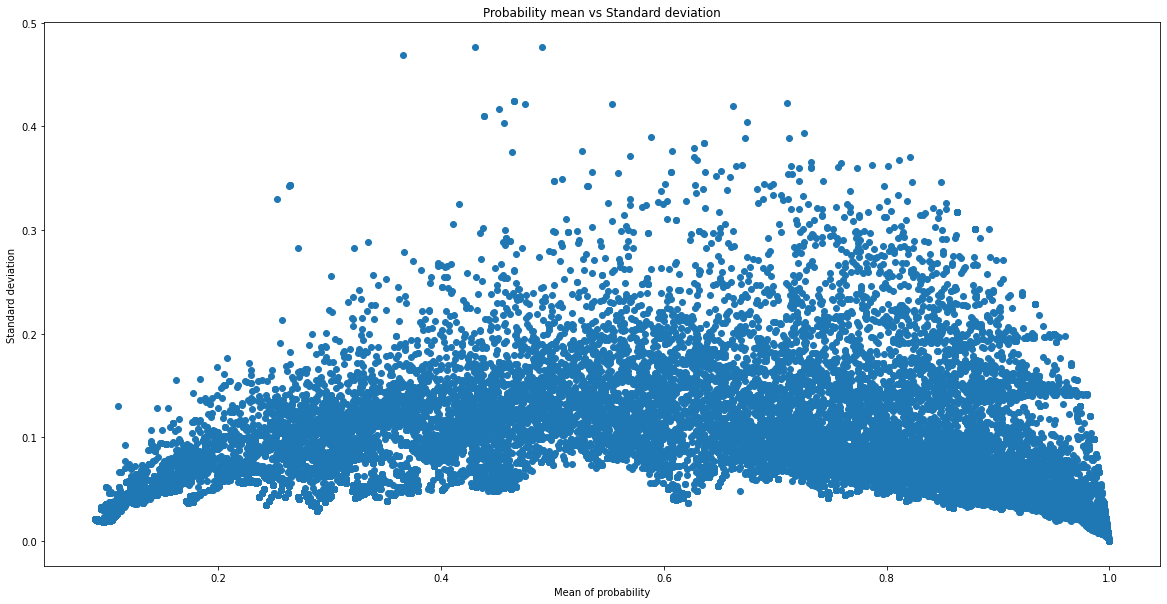

In [30]:
plot_generic(means, stds, "Mean of probability", "Standard deviation", "Probability mean vs Standard deviation")

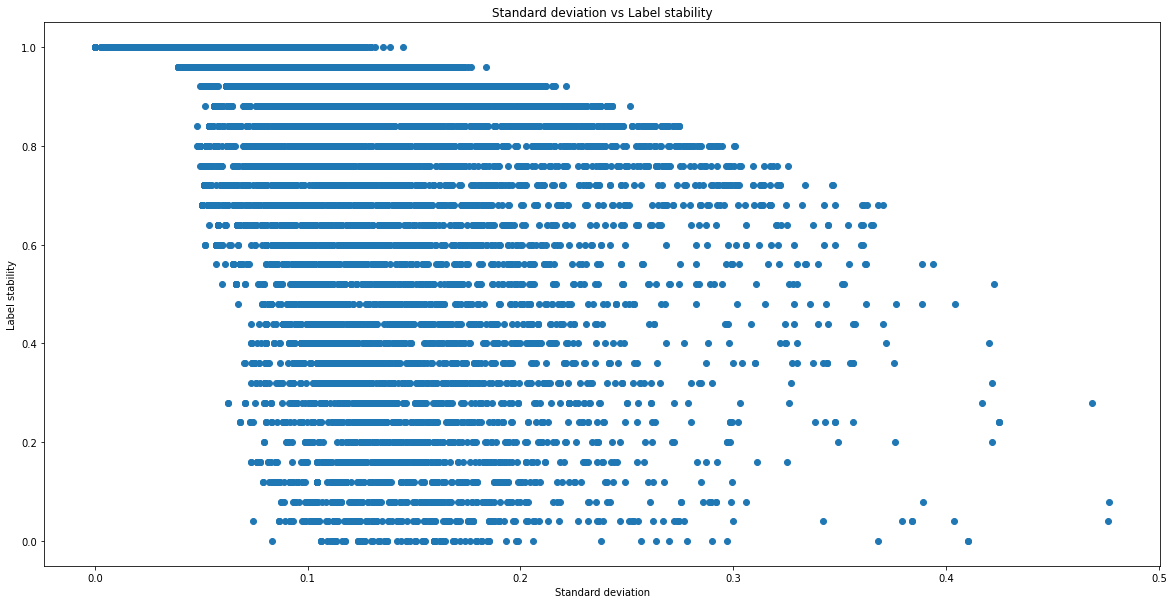

In [31]:
plot_generic(stds, label_stability, "Standard deviation", "Label stability", "Standard deviation vs Label stability")

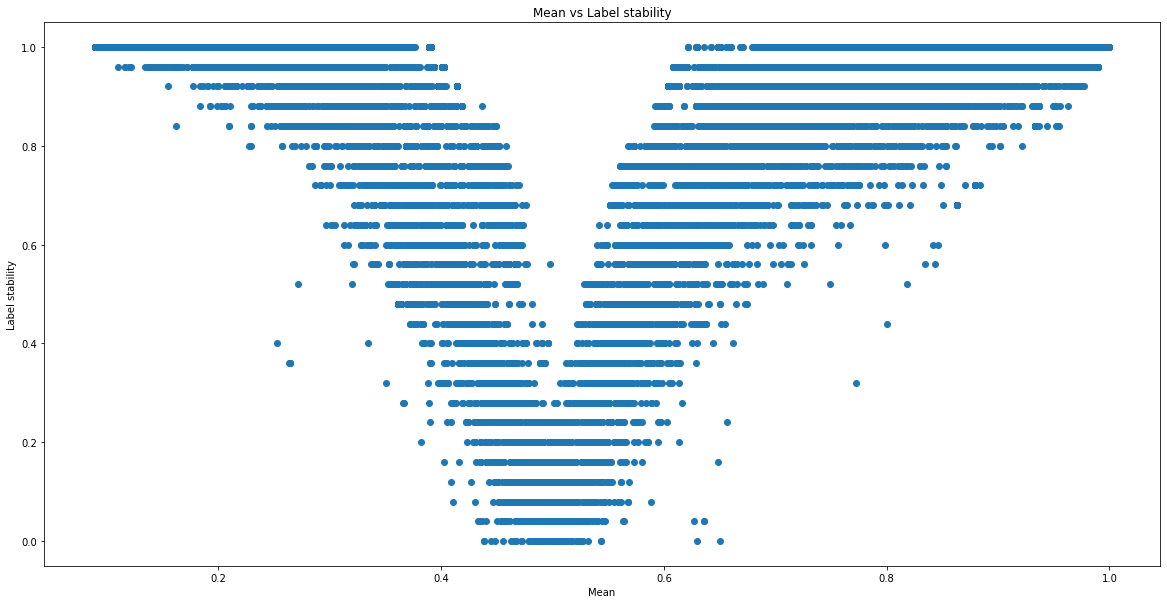

In [32]:
plot_generic(means, label_stability, "Mean", "Label stability", "Mean vs Label stability")

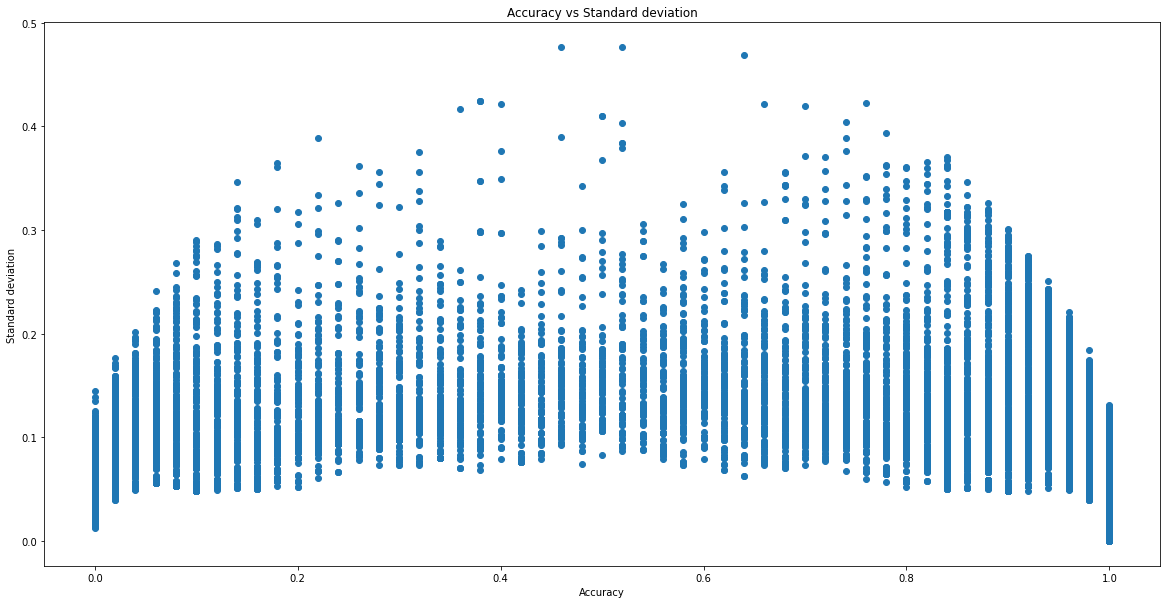

In [33]:
plot_generic(per_sample_accuracy, stds, "Accuracy", "Standard deviation", "Accuracy vs Standard deviation")

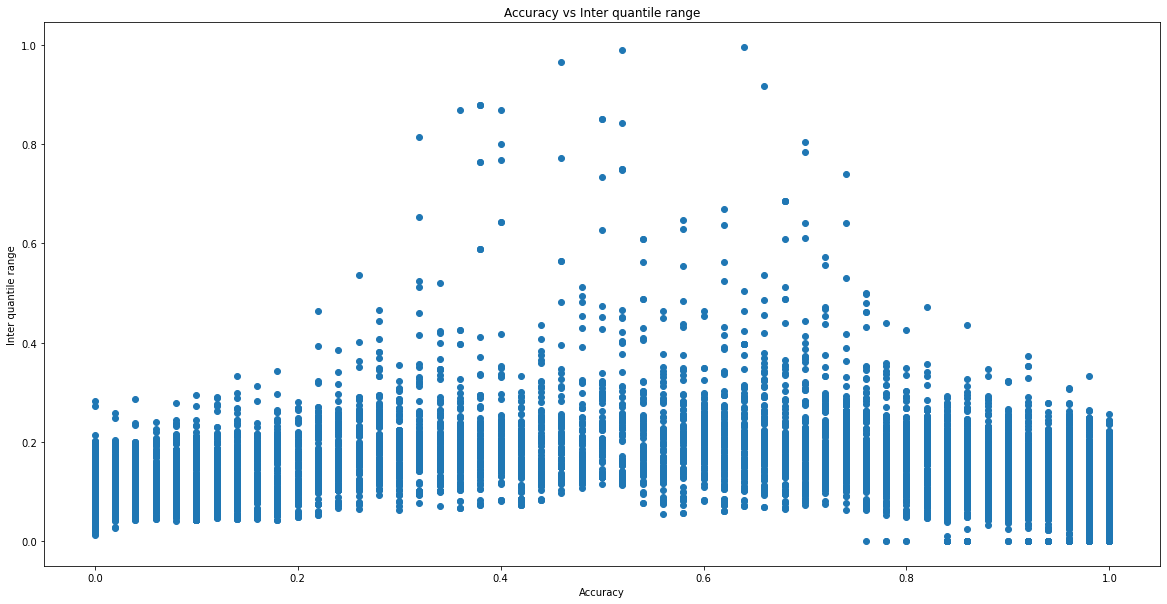

In [34]:
plot_generic(per_sample_accuracy, iqr, "Accuracy", "Inter quantile range", "Accuracy vs Inter quantile range")

In [35]:
fairness_metrics = {}
metrics = ['Accuracy', 'Disparate_Impact', 'Equal_Opportunity', 'Statistical_Parity_Difference']
for metric in metrics:
            fairness_metrics[metric]= compute_metric(y_preds, y_val, val_groups, metric)

fairness_metrics

{'Accuracy':               Race       Sex  Race_Sex
 adv       0.830786  0.865844  0.867011
 disadv    0.832888  0.797189  0.820811
 Accuracy -0.002102  0.068655  0.046199,
 'Disparate_Impact':                       Race       Sex  Race_Sex
 adv               0.505889  0.519343  0.528516
 disadv            0.472148  0.479970  0.506386
 Disparate_Impact  0.933304  0.924187  0.958129,
 'Equal_Opportunity':                        Race       Sex  Race_Sex
 adv                0.871911  0.896737  0.895787
 disadv             0.870310  0.839328  0.871904
 Equal_Opportunity  0.001601  0.057409  0.023883,
 'Statistical_Parity_Difference':                                    Race       Sex  Race_Sex
 adv                            1.117670  1.069831  1.057727
 disadv                         1.146364  1.175262  1.151153
 Statistical_Parity_Difference -0.028695 -0.105431 -0.093425}

In [36]:
y_preds = np.array([int(x<0.5) for x in results.mean().values])
accuracy = np.mean(np.array([y_preds[i] == y_val[i] for i in range(len(y_val))]))
accuracy

0.8308673323278413

In [37]:
metrics_to_report={}
metrics_to_report['Accuracy'] = accuracy
metrics_to_report['Label_stability'] = [np.mean(label_stability)]
metrics_to_report['SD'] = [np.mean(stds)]
metrics_to_report['IQR'] = [np.mean(iqr)]
metrics_to_report['SPD_Race'] = [fairness_metrics['Statistical_Parity_Difference']['Race'].loc['Statistical_Parity_Difference']]
metrics_to_report['SPD_Sex'] = [fairness_metrics['Statistical_Parity_Difference']['Sex'].loc['Statistical_Parity_Difference']]
metrics_to_report['SPD_Race_Sex'] = [fairness_metrics['Statistical_Parity_Difference']['Race_Sex'].loc['Statistical_Parity_Difference']]
metrics_to_report['EO_Race'] = [fairness_metrics['Equal_Opportunity']['Race'].loc['Equal_Opportunity']]
metrics_to_report['EO_Sex'] = [fairness_metrics['Equal_Opportunity']['Sex'].loc['Equal_Opportunity']]
metrics_to_report['EO_Race_Sex'] = [fairness_metrics['Equal_Opportunity']['Race_Sex'].loc['Equal_Opportunity']]



pd.DataFrame(metrics_to_report)

,Accuracy,Label_stability,SD,IQR,SPD_Race,SPD_Sex,SPD_Race_Sex,EO_Race,EO_Sex,EO_Race_Sex
0,0.830867,0.925705,0.056636,0.066931,-0.028695,-0.105431,-0.093425,0.001601,0.057409,0.023883


In [38]:
import pickle

f = open("TX_2016_baseline.pkl","wb")
pickle.dump(metrics_to_report,f)
f.close()